In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
tf.test.gpu_device_name() #run to make sure tensorflow is connected to gpu

import numpy as np
import pandas as pd
import cv2  
import os  
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show
%matplotlib inline

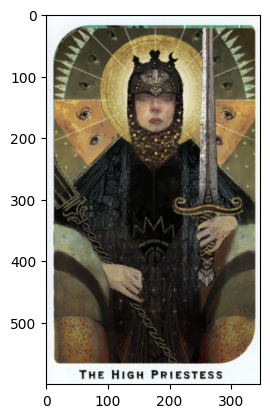

In [2]:
image = imread('cards/m02.jpg')
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
imshow(images[0])
show()


      

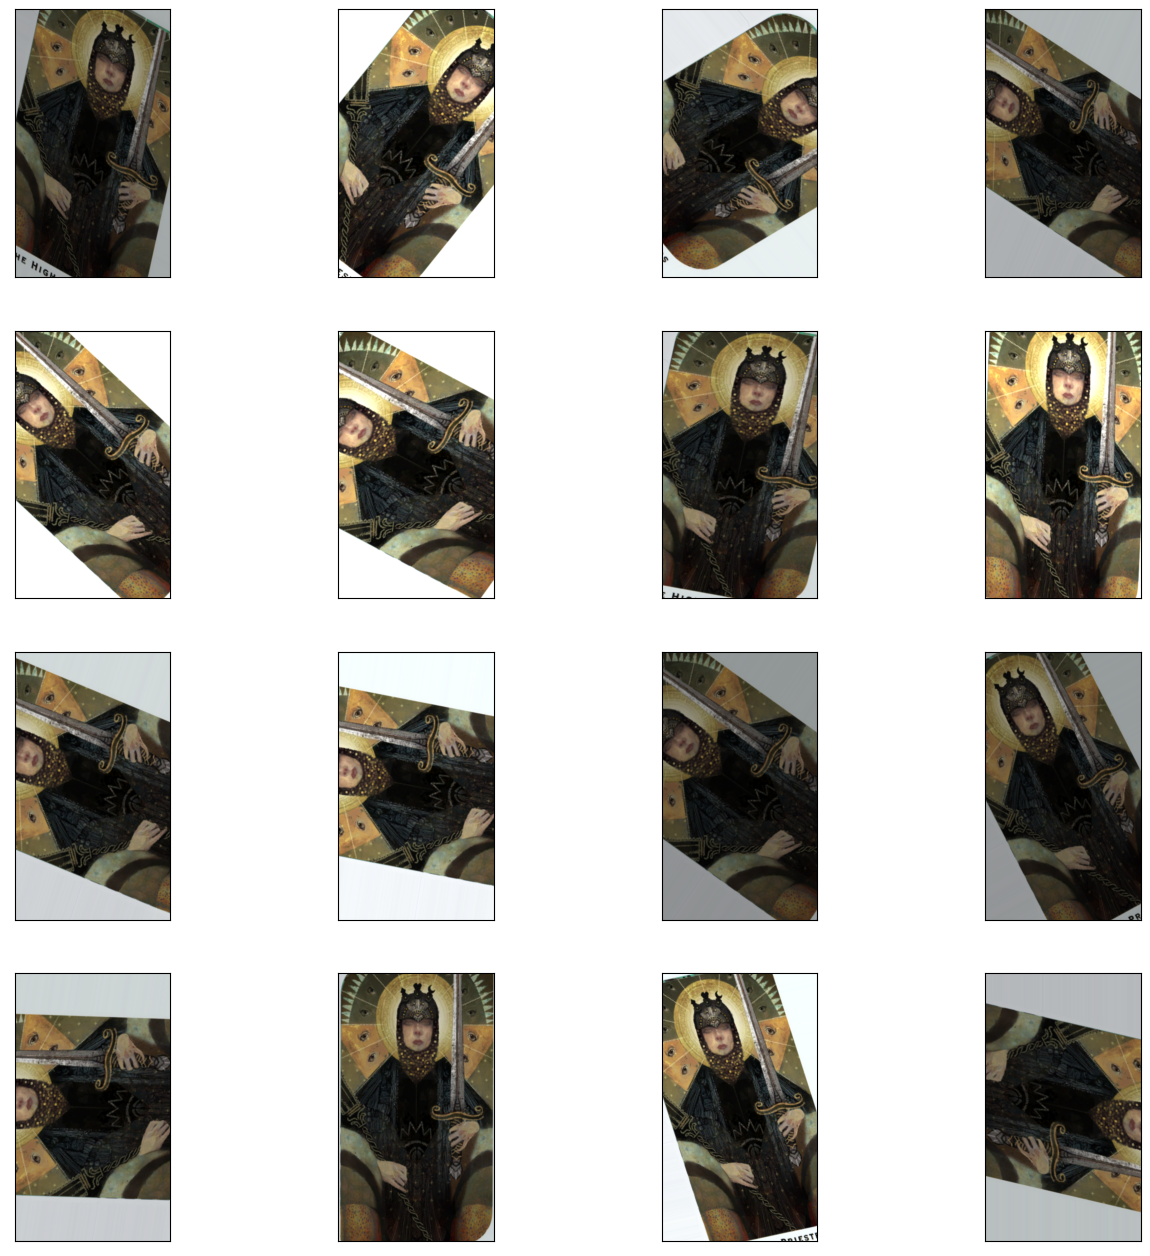

In [3]:
data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[1, .8])
data_generator.fit(images)
image_iterator = data_generator.flow(images)

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_iterator.next()[0].astype('int'))
plt.show()

In [4]:
data=[]

for i, img in tqdm(enumerate(os.listdir('cards/'))):
    label=i
    
    img = cv2.imread('cards/'+img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (180, 180))
    imgs = img.reshape((1, img.shape[0], img.shape[1], 1))
    data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[1, .8])
    data_generator.fit(imgs)
    image_iterator = data_generator.flow(imgs)
    
    for x in range(100):
        img_transformed=image_iterator.next()[0].astype('int')/255
        data.append([img_transformed, label])

shuffle(data)
len(data)


78it [00:26,  2.95it/s]


7800

# preprocessing + augmentation

In [5]:

train=data[:3900]
test=data[3900:]

train_X=[]
train_y=[]
for x in train:
    train_X.append(x[0]) 
    train_y.append(x[1])
    
test_X=[]
test_y=[]
for x in test:
    test_X.append(x[0]) 
    test_y.append(x[1])
    
train_X=np.array(train_X)
train_y=np.array(train_y)

test_X=np.array(test_X)
test_y=np.array(test_y)




In [6]:

tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

epochs=50
batch_size=10

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(train_X.shape[1], train_X.shape[2], train_X.shape[3])),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(78, activation='softmax')
])

model.summary()

cp = tf.keras.callbacks.ModelCheckpoint(filepath="50epochs_conv.h5",
                               save_best_only=True,
                               verbose=0)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, test_y), callbacks=[cp]).history




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

# modelling

## prep

122/122 [==============================] - 135s 1s/step


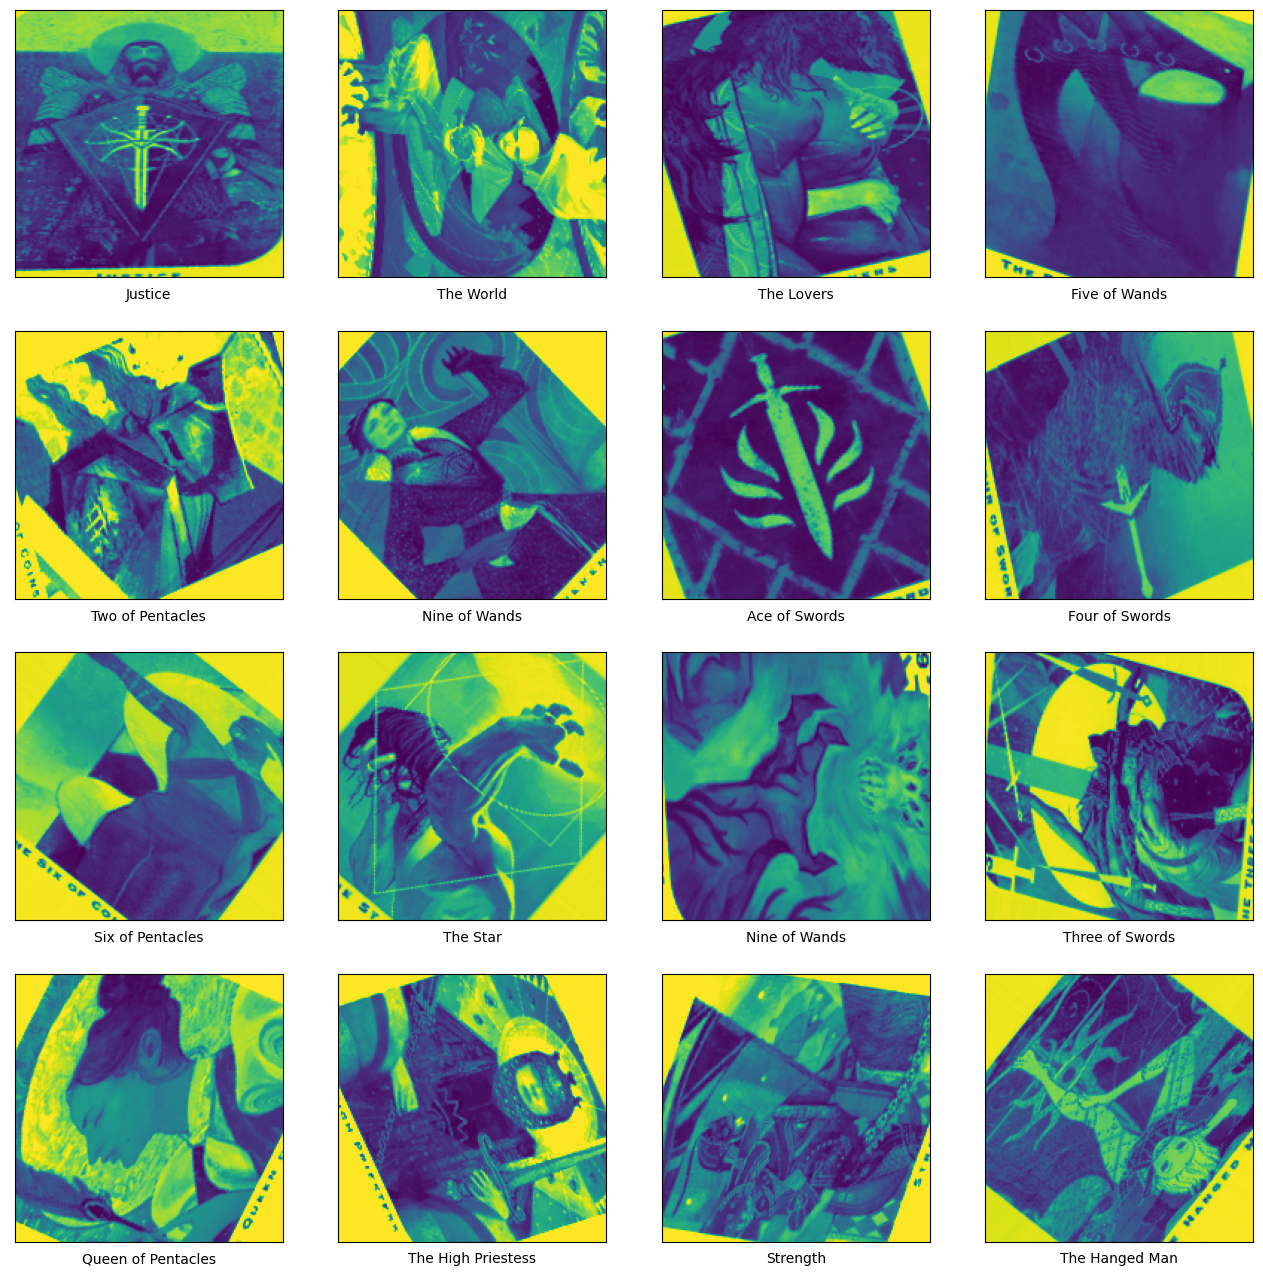

In [7]:


df=pd.read_csv('tarot-images.csv')
labels=list(df['name'])

predict_x=model.predict(test_X) 
classes_x=np.argmax(predict_x,axis=1)

sample=test_X[:16]

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample[i].reshape(sample.shape[1], sample.shape[2]))
    plt.xlabel(labels[classes_x[i]])
plt.show()

In [8]:
pred = model.predict(Test)
label_predicted=np.argmax(pred, axis=-1)

label_predicted

NameError: name 'Test' is not defined

In [8]:

submission = pd.DataFrame({'image_id':'m01.jpg' ,'label':label_predicted})
submission.to_csv("submission.csv", index = False, header = True)

## training

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0321 - accuracy: 0.9966 - val_loss: 0.0236 - val_accuracy: 0.9970
Epoch 43/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0401 - accuracy: 0.9962 - val_loss: 0.0914 - val_accuracy: 0.9915
Epoch 44/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0429 - accuracy: 0.9963 - val_loss: 0.0797 - val_accuracy: 0.9925
Epoch 45/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0432 - accuracy: 0.9964 - val_loss: 0.0348 - val_accuracy: 0.9960
Epoch 46/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0369 - accuracy: 0.9967 - val_loss: 0.0599 - val_accuracy: 0.9970
Epoch 47/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0445 - accuracy: 0.9968 - val_loss: 0.0484 - val_accuracy: 0.9960
Epoch 48/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0447 - accuracy: 0.996

37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0320 - accuracy: 0.9986 - val_loss: 0.0221 - val_accuracy: 0.9985
Epoch 97/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0435 - accuracy: 0.9983 - val_loss: 0.1089 - val_accuracy: 0.9965
Epoch 98/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0399 - accuracy: 0.9987 - val_loss: 0.0678 - val_accuracy: 0.9980
Epoch 99/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0366 - accuracy: 0.9984 - val_loss: 0.0845 - val_accuracy: 0.9970
Epoch 100/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0664 - accuracy: 0.9978 - val_loss: 0.0797 - val_accuracy: 0.9960
Epoch 101/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0466 - accuracy: 0.9980 - val_loss: 0.0645 - val_accuracy: 0.9985
Epoch 102/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0334 - accuracy: 0.

37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0733 - accuracy: 0.9982 - val_loss: 0.1183 - val_accuracy: 0.9965
Epoch 151/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0488 - accuracy: 0.9987 - val_loss: 0.0344 - val_accuracy: 0.9985
Epoch 152/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0619 - accuracy: 0.9984 - val_loss: 0.1236 - val_accuracy: 0.9970
Epoch 153/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0467 - accuracy: 0.9988 - val_loss: 0.0996 - val_accuracy: 0.9985
Epoch 154/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0593 - accuracy: 0.9981 - val_loss: 0.0545 - val_accuracy: 0.9990
Epoch 155/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0498 - accuracy: 0.9987 - val_loss: 0.0366 - val_accuracy: 0.9985
Epoch 156/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0351 - accuracy:

Epoch 204/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0537 - accuracy: 0.9989 - val_loss: 0.0287 - val_accuracy: 0.9990
Epoch 205/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0722 - accuracy: 0.9988 - val_loss: 0.1064 - val_accuracy: 0.9975
Epoch 206/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0701 - accuracy: 0.9989 - val_loss: 0.0825 - val_accuracy: 0.9985
Epoch 207/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0421 - accuracy: 0.9994 - val_loss: 0.1249 - val_accuracy: 0.9980
Epoch 208/250
37000/37000 [==============================] - 43s 1ms/sample - loss: 0.0778 - accuracy: 0.9987 - val_loss: 0.1325 - val_accuracy: 0.9980
Epoch 209/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.0584 - accuracy: 0.9988 - val_loss: 0.0254 - val_accuracy: 0.9980
Epoch 210/250
37000/37000 [==============================] - 42s 1ms/sample - loss: 0.07

## training process plots

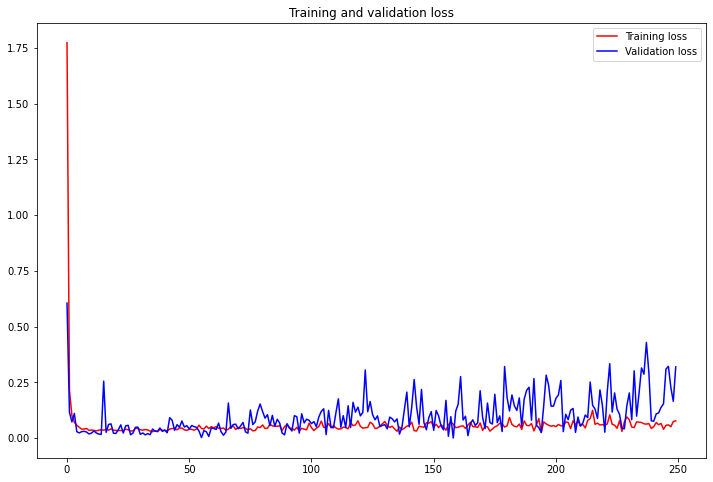

<Figure size 432x288 with 0 Axes>

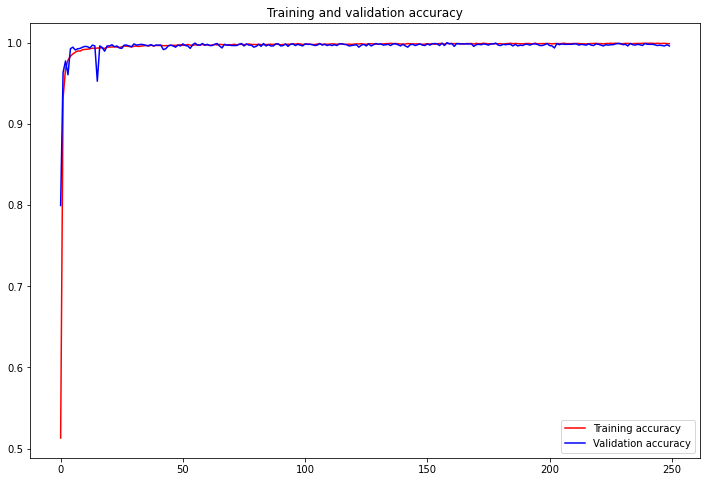

<Figure size 432x288 with 0 Axes>

# sample prediction

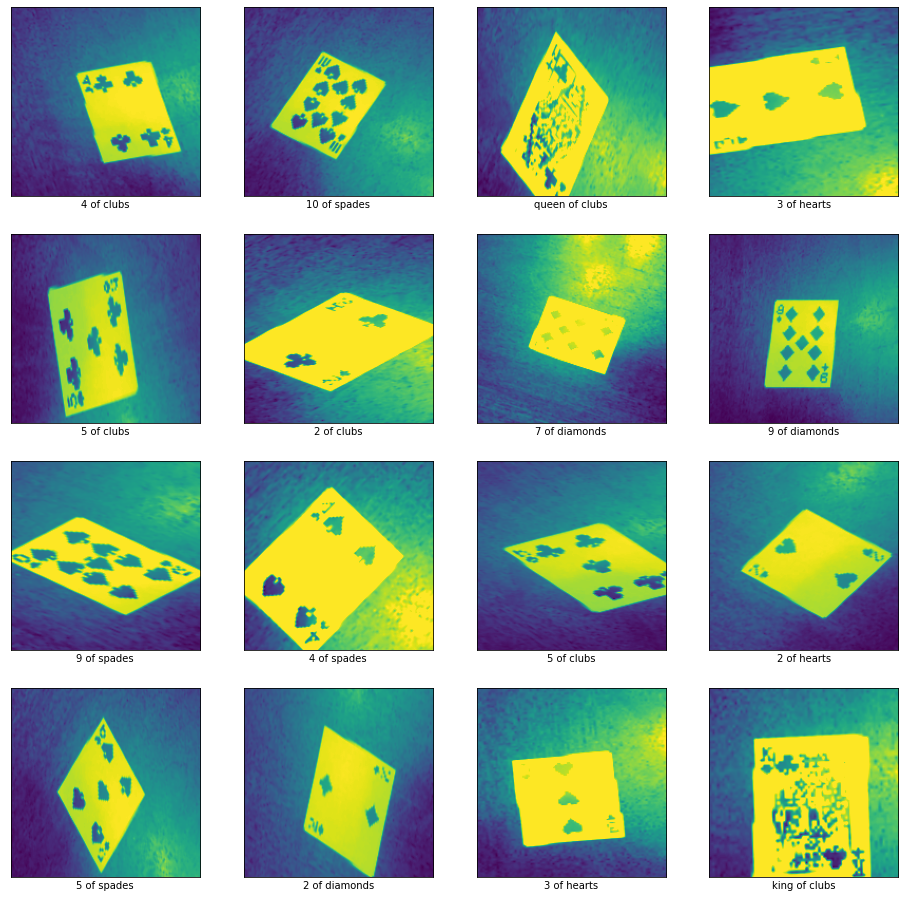